In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

In [2]:
city = 'Karlsruhe'

# Photovoltaic Systems in {{city}}

We consider data from the dump files:
- `200303_MaStR-Daten_registriert_ab_31-01-2019.xlsx` systems activated since 2019-01-31
- `190703_MaStRDaten_MIGRATION_Teil1.xlsx` systems activated before 2019-02-01
- `190703_MaStRDaten_MIGRATION_Teil2.xlsx` systems activated before 2019-02-01

In [3]:
!ls -lh "/data"

total 627M
-rw-r--r-- 1 jovyan  1000 315K Jun 14 18:46 190703_MaStRDaten_MIGRATION_Teil1_Karlsruhe.csv
-rw-r--r-- 1 jovyan users 324K Jun 23 23:49 190703_MaStRDaten_MIGRATION_Teil1_Karlsruhe_vor010219.csv
-rw-r--r-- 1 jovyan  1000 309K Jun 14 19:16 190703_MaStRDaten_MIGRATION_Teil2_Karlsruhe.csv
-rw-r--r-- 1 jovyan users 318K Jun 23 23:49 190703_MaStRDaten_MIGRATION_Teil2_Karlsruhe_vor010219.csv
-rw-r--r-- 1 jovyan users 155K Jun 20 13:25 200303_MaStRDaten_ab310119_Karlsruhe.csv
-rw-r--r-- 1 jovyan users 348K Jun 20 13:25 200303_MaStRDaten_vor010219_Karlsruhe.csv
drwxr-xr-x 2 jovyan  1000 4.0K Jun 16 20:41 DatenAb310119
-rw-r--r-- 1 jovyan  1000 307M Jun 11 18:07 DatenAb310119.zip
-rwxr-xr-x 1 jovyan  1000  769 Jun 17 22:59 download.sh
-rw-r--r-- 1 jovyan users  16K Jun 24 23:13 karlsruhe-PV-withLatLon.csv
drwxr-xr-x 2 jovyan  1000 4.0K Jun 23 23:19 MaStRDatenMigration1
-rw-r--r-- 1 jovyan  1000 185M Jun 11 18:07 MaStRDatenMigration1.zip
drwxr-xr-x 2 jovyan  1000 4.0K Jun 16 21:18 MaSt

In [4]:
csvNew = pd.read_csv('/data/200303_MaStRDaten_ab310119_Karlsruhe.csv')
csv2 = pd.read_csv('/data/190703_MaStRDaten_MIGRATION_Teil1_Karlsruhe_vor010219.csv')
csv3 = pd.read_csv('/data/190703_MaStRDaten_MIGRATION_Teil2_Karlsruhe_vor010219.csv')

In [5]:
for csv in [csvNew, csv2, csv3]:
    print(csv.shape)
    print(csv['ENH_EinheitenTyp'].value_counts())

(296, 74)
Solareinheit            195
Stromspeichereinheit     93
Verbrennung               8
Name: ENH_EinheitenTyp, dtype: int64
(1227, 24)
Solareinheit    1227
Name: ENH_EinheitenTyp, dtype: int64
(1208, 40)
Solareinheit            1119
Stromspeichereinheit      49
Verbrennung               27
Biomasse                   6
Windeinheit                5
Wasser                     2
Name: ENH_EinheitenTyp, dtype: int64


In [6]:
csvOld = csv2.append(csv3)
print(csvOld.shape)
print(csvOld['ENH_EinheitenTyp'].value_counts())

(2435, 40)
Solareinheit            2346
Stromspeichereinheit      49
Verbrennung               27
Biomasse                   6
Windeinheit                5
Wasser                     2
Name: ENH_EinheitenTyp, dtype: int64


Reset the index after appending two data frames.

In [7]:
csvOld['ENH_InbetriebnahmeDatum'][0]

0    2010-11-15 00:00:00
0    2016-04-04 00:00:00
Name: ENH_InbetriebnahmeDatum, dtype: object

In [8]:
csvOld.reset_index(drop=True, inplace=True)
csvOld['ENH_InbetriebnahmeDatum'][0]

'2010-11-15 00:00:00'

Combine old a new data.

In [9]:
csv = csvNew.append(csvOld)
csv.reset_index(drop=True, inplace=True)
print(csv.shape)
print(csv['ENH_EinheitenTyp'].value_counts())

(2731, 77)
Solareinheit            2541
Stromspeichereinheit     142
Verbrennung               35
Biomasse                   6
Windeinheit                5
Wasser                     2
Name: ENH_EinheitenTyp, dtype: int64


Fix zip codes by restoring integer values.

In [10]:
csv = csv.assign(ENH_Plz = csv['ENH_Plz'].astype('int32'))
csv.ENH_Plz.value_counts()

76228    509
76149    377
76227    253
76189    253
76187    248
76139    232
76185    209
76229    199
76199    144
76131    105
76133     80
76135     72
76137     49
76448      1
Name: ENH_Plz, dtype: int64

Filter by photovoltaic systems.

In [11]:
pv = csv.loc[csv['ENH_EinheitenTyp'] == 'Solareinheit']

In [12]:
pv['ENH_Betriebsstatus'].value_counts()

In Betrieb    2541
Name: ENH_Betriebsstatus, dtype: int64

In [13]:
interestingColumns = ['ENH_Strasse', 'ENH_Hausnummer', 'ENH_Plz', 'ENH_Ort', 'ENH_Bruttoleistung', 'ENH_Breitengrad',
       'ENH_Laengengrad', 'ENH_InbetriebnahmeDatum', 'ENH_Betriebsstatus']

In [14]:
activationDates = pv['ENH_InbetriebnahmeDatum']
notYetActivated = activationDates[activationDates.isna()]
print("number of plants that are not yet activated:", notYetActivated.size)

number of plants that are not yet activated: 0


In [15]:
pv = pv.assign(InbetriebnahmeDatum_Year = pd.DatetimeIndex(pv['ENH_InbetriebnahmeDatum']).year)
pv.InbetriebnahmeDatum_Year.value_counts()

2011    339
2010    335
2012    253
2009    204
2019    179
2013    173
2008    131
2018    121
2017    118
2007    113
2014     99
2016     90
2006     89
2015     86
2005     71
2000     34
2020     24
2001     21
2004     21
2002     18
2003     17
1992      2
1995      1
1998      1
1996      1
Name: InbetriebnahmeDatum_Year, dtype: int64

In [16]:
pvPerYear = pv.groupby('InbetriebnahmeDatum_Year').agg(
    count=pd.NamedAgg(column='ENH_Bruttoleistung', aggfunc='count'), 
    grossPower=pd.NamedAgg(column='ENH_Bruttoleistung', aggfunc='sum'),
    netPower=pd.NamedAgg(column='ENH_Nettonennleistung', aggfunc='sum')
).reset_index()
pvPerYear.set_index('InbetriebnahmeDatum_Year', inplace=True)
pvPerYear

,count,grossPower,netPower
InbetriebnahmeDatum_Year,,,
1992,2,6.496,6.496
1995,1,3.400,3.400
1996,1,1.500,1.500
1998,1,1.500,1.500
2000,34,422.590,422.590
2001,21,95.540,95.540
2002,18,47.270,47.270
2003,17,50.783,50.783
2004,21,90.597,90.597


Text(0, 0.5, 'power in W')

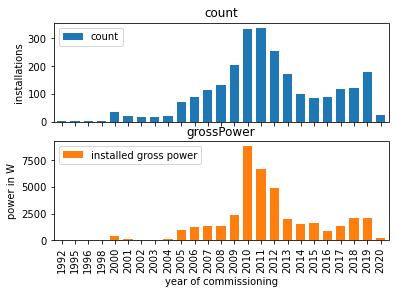

In [17]:
axes = pvPerYear.plot.bar(y=['count', 'grossPower'], width=0.7, subplots=True)
axes[0].set_ylabel('installations')
axes[0].legend(loc=2)
axes[1].set_xlabel('year of commissioning')
axes[1].legend(['installed gross power'], loc=2)
axes[1].set_ylabel('power in W')

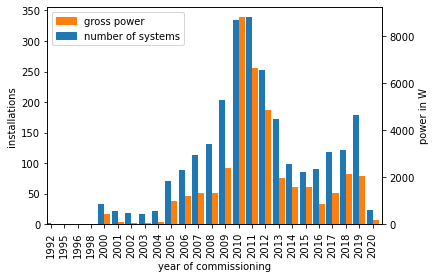

In [18]:
fig, ax = plt.subplots()
ax2 = ax.twinx()
width = 0.45
count = pvPerYear['count'].plot(
    kind='bar', color='tab:blue', ax=ax, width=width, position=1)
ax.set_ylabel('installations')
power = pvPerYear['grossPower'].plot(
    kind='bar', color='tab:orange', ax=ax2, width=width, position=0)
ax2.set_ylabel('power in W')
ax.set_xlabel('year of commissioning')
orange = mpatches.Patch(color='tab:orange', label='gross power')
blue = mpatches.Patch(color='tab:blue', label='number of systems')
plt.legend(handles=[orange, blue], loc=2)
plt.ion()

### Histogram of net power

In [19]:
power = pv[['ENH_Bruttoleistung', 'ENH_Nettonennleistung']]
power.describe()

,ENH_Bruttoleistung,ENH_Nettonennleistung
count,2541.000000,2541.000000
mean,15.747481,15.693161
std,47.879889,47.832927
min,0.150000,0.150000
25%,4.410000,4.410000
50%,6.500000,6.480000
75%,9.920000,9.900000
max,998.870000,998.870000


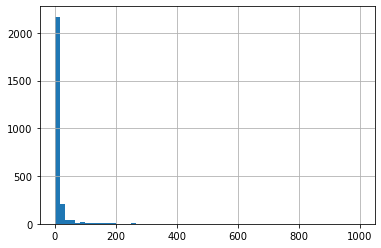

In [20]:
grossPower = power['ENH_Bruttoleistung']
grossPower.hist(bins=60)

In [21]:
count, bins = np.histogram(grossPower, bins=60)
for index in range(count.size):
    print('[%0.2f, %0.2f]: %d' % (bins[index], bins[index + 1], count[index]))

[0.15, 16.80]: 2168
[16.80, 33.44]: 206
[33.44, 50.09]: 44
[50.09, 66.73]: 40
[66.73, 83.38]: 11
[83.38, 100.02]: 14
[100.02, 116.67]: 5
[116.67, 133.31]: 9
[133.31, 149.96]: 5
[149.96, 166.60]: 5
[166.60, 183.25]: 4
[183.25, 199.89]: 4
[199.89, 216.54]: 1
[216.54, 233.18]: 3
[233.18, 249.83]: 2
[249.83, 266.48]: 5
[266.48, 283.12]: 0
[283.12, 299.77]: 2
[299.77, 316.41]: 1
[316.41, 333.06]: 3
[333.06, 349.70]: 1
[349.70, 366.35]: 1
[366.35, 382.99]: 0
[382.99, 399.64]: 0
[399.64, 416.28]: 0
[416.28, 432.93]: 1
[432.93, 449.57]: 0
[449.57, 466.22]: 0
[466.22, 482.86]: 0
[482.86, 499.51]: 0
[499.51, 516.16]: 0
[516.16, 532.80]: 1
[532.80, 549.45]: 0
[549.45, 566.09]: 0
[566.09, 582.74]: 0
[582.74, 599.38]: 0
[599.38, 616.03]: 0
[616.03, 632.67]: 1
[632.67, 649.32]: 0
[649.32, 665.96]: 0
[665.96, 682.61]: 0
[682.61, 699.25]: 0
[699.25, 715.90]: 1
[715.90, 732.54]: 0
[732.54, 749.19]: 0
[749.19, 765.84]: 0
[765.84, 782.48]: 0
[782.48, 799.13]: 0
[799.13, 815.77]: 2
[815.77, 832.42]: 0
[83

### Geo-Coordinates

In [22]:
hasLat = ~pv.ENH_Laengengrad.isna()
hasLon = ~pv.ENH_Breitengrad.isna()
systemsWithCoordinates = pv.loc[hasLat & hasLon]
systemsWithCoordinatesClean = systemsWithCoordinates[interestingColumns].reset_index(drop=True)

In [23]:
systemsWithCoordinatesClean.to_csv("/data/karlsruhe-PV-withLatLon.csv")